# Tutorial #1: Probability distributions and error bars

In [1]:
# Set matplotlib to plot in the notebook
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Note: unlike MATLAB, Python has the concepts of namespaces and explicit imports.
Objects from the ``numpy`` and ``matplotlib`` namespaces are availible because we are using ``pylab``,
although this is fine in an interactive or notebook session it's considered proper to explicitly name them
(i.e. ``import numpy as np; imoprt matplotlib.pyplot as plt``) when writing persistant code.

Let's also import our plotting backend manipulator for attractive plots and some utilities to go along with the course

In [2]:
from __future__ import division
import utils
import seaborn
seaborn.set()
colors = seaborn.color_palette()

### (1) Exploring a simple data set; one variable, one condition

Simulating data is incredibly useful.

The function ``randn()`` generates data
containing values that are randomly drawn from a gaussian distribution
with a zero mean and unit variance (a standard normal).

You can also generate random gaussian values with the ``normal()`` function,
which allows you to specify the mean and variance of the distribution you will sample from.

Take care not to confuse ``randn()`` with ``rand()``, which draws from a uniform distribution between 0 and 1.

We will be using this function regularly throughout the course.

Note that if you are not using ``pylab``, both these functions are found in the ``numpy.random`` subpackage of numpy.

In [3]:
# Start by generating a dataset and calculating some statistics
d = randn(100)
m = d.mean()
s = d.std()

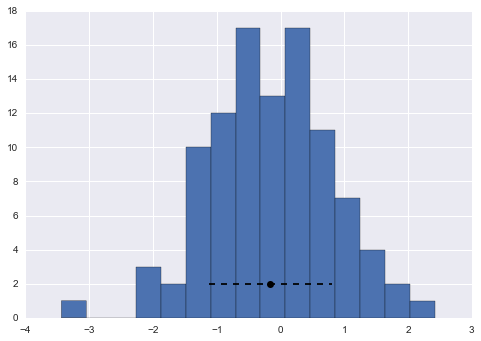

In [4]:
# Now plot a histogram of the data with 15 bins
hist(d, 15)

m_y = 2

# Add a plot of the mean and standard deviation range
plot(m, m_y, "ko")
plot([m - s, m + s], [m_y] * 2, "k--");

In [5]:
# Now let's find the medium and interquartile range
med = median(d)
iqr = utils.percentiles(d, [25, 75])

# Plot the data with this summary
hist(d, 15)
plot(med, m_y, "ko")
plot(iqr, [m_y] * 2, "k--");

AttributeError: 'module' object has no attribute 'percentiles'

Notice that the mean and median are very similar for these data. This is an important feature of the gaussian distribution.

If data is gaussian then (1) the mean and the median will on-average approximate
each other (more so, the more data you have) and (2) mean +/- 1 standard
deviation spans from the 16th to the 84th percentile (i.e. 50% +/- 68%/2).

Lets check this assertion by plotting these percentiles around the mean


In [6]:
# Let's define a function to streamline the central tendency and error bar plots from above
def ctend_plot(point, ci, y, color, label):
    plot(ci, [y, y], "-", color=color, linewidth=4, label=label)
    plot(point, y, "o", color=color, markersize=10)

AttributeError: 'module' object has no attribute 'percentiles'

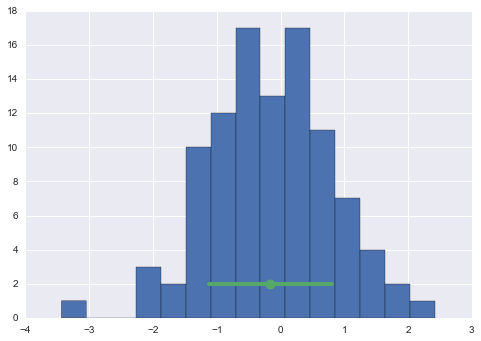

In [7]:
hist(d, 15)
ctend_plot(m, [m - s, m + s], m_y, colors[1], "std dev")

ci = utils.percentiles(d, [16, 84])
ctend_plot(med, ci,  m_y - 1, colors[2], "68% CI")
legend();

Now let's look at the effect of an outlier. Notice that when we add
outliers to the data the mean does not accurately describe the
central tendency of the data and the standard deviation does not
accurately reflect the spread in the data.

In [8]:
d1 = concatenate([d, [40, 41, 45]])
m1 = d1.mean()
s1 = d1.std()
med1 = median(d1)
ci1 = percentile(d1, [16, 84])

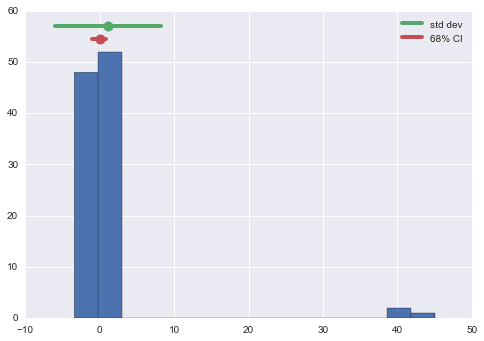

In [9]:
hist(d1, 15)
# Find some space near the top of the plot
m_y = histogram(d1, 15)[0].max() + 5
ctend_plot(m1, [m1 - s1, m1 + s1], m_y, colors[1], "std dev")
ctend_plot(med1, ci1, m_y - 2.5, colors[2], "68% CI")
legend();

Notice that in this plot the mean is much higher than the median and the
standard deviation is massive.  

Neither the median nor the percentiles are drastically affected by the outliers.

Notice that the mean is higher than the 84th percentile.  This means that the mean is higher than 84% of
the values in the data.

Given this distribution the mean and standard deviation are poor representations of the central tendency and spread of the data.

### (2) Probability distributions

The equation for a gaussian is:

$$p(x) = \frac{1}{\sigma\sqrt{2\pi}}\exp[-\frac{1}{2}(\frac{x - \mu}{\sigma})^2]$$

where $\mu$ is the mean and $\sigma$ is the standard deviation.

We can plot the gaussian function with the approriate parameters on both histograms and see how well they fit the data.

In [10]:
# First create a vector of x values spanning the support of the histogram
x = linspace(d.min(), d.max(), 1000)

# Let's define a function to calculate the gaussian function for a given x, mean, and std
gauss = lambda x, m, s: (1 / (s * sqrt(2 * pi)) * exp(-0.5 * ((x - m) / s) ** 2))

# We could iterate through the x values and calculate a y value for each using this equation
y0 = zeros_like(x)
for i, x_i in enumerate(x):
    y0[i] = gauss(x_i, m, s)

# You can also do it in one step with a vectorized computation.
# In general, avoid for loops, as vectorized expressions are much faster.
y = gauss(x, m, s)

NOTE: MATLAB and Python (specifically numpy) differ here.
Regular arithmetic is elementwise in numpy
i.e.: x * y in python is equivalent to x *. y in MATLAB
Use the dot() function or np.matrix objects for matrix operations

Now plot the gaussian curve over the histogram

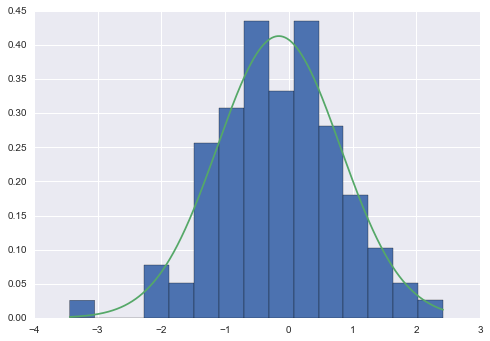

In [11]:
# Use a normed histogram to match the range of the probaiblity density function
hist(d, 15, normed=True)
plot(x, y);

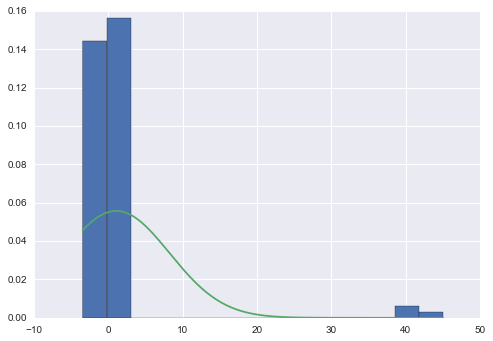

In [13]:
# Calculate the height of the gaussian for the outlier distribution and plot
x1 = linspace(d1.min(), d1.max(), 10000)
y1 = gauss(x1, m1, s1)
hist(d1, 15, normed=True)
plot(x1, y1);

Notice that the Gaussian is a good description of the data when the data
does in fact come from a Gaussian distribution but is a poor
description when the data is non-Gaussian because of the outliers.

In case you were wondering, there are easier ways to generate gaussian distributions in Python.

The ``scipy.stats`` package offers many distribution objects that let you evaluate pdfs, cdfs, and draw random values

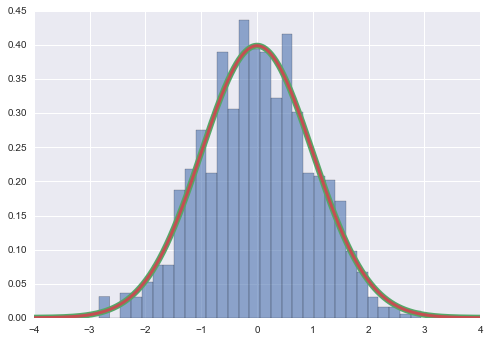

In [14]:
from scipy import stats
x = linspace(-4, 4, 10001)
hist(stats.norm(0, 1).rvs(1000), 30, normed=True, alpha=.6)
plot(x, stats.norm(0, 1).pdf(x), linewidth=6)
plot(x, gauss(x, 0, 1), linewidth=3);

Note how the distributions lie directly on top of each other

### (3) Error bars

First lets simulate a population of 10,000 data points.
Assume that for whatever we are  measuring this represents the full
population of measurements.

In [15]:
s = 10000
N = randn(s)

To randomly sample from the population, we will use the ``randint`` function, which draws from a "discrete uniform" distibution.

We will use the returned values as indices into the population array.

Note that this will sample *with* replacement.

In [16]:
sample_size = 100
n = N[randint(0, s, sample_size)]

In [17]:
# Get the standard error of the mean and 95% CI for the sample
sem1 = n.std() / sqrt(sample_size)
m1 = n.mean()
ci1 = m1 - 2 * sem1, m1 + 2 * sem1

We can show that the 95% confidence interval obtained from the standard
error of the mean aproximates the variability in the mean that would be
obtained when many independent random samples are taken from the
population.

In [18]:
n_samples = 10000
mu = array([N[randint(0, s, sample_size)].mean() for i in xrange(n_samples)])
sem2 = mu.std()
ci2 = utils.percentiles(mu, [2.5, 97.5])

AttributeError: 'module' object has no attribute 'percentiles'

Now we'll visualize these results.

NameError: name 'ci2' is not defined

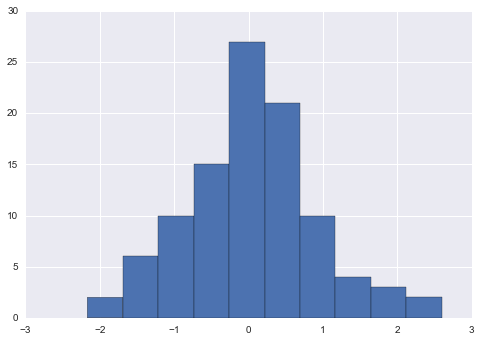

In [19]:
hist(n)
ctend_plot(N.mean(), ci2, 3, colors[4], "poplation mean")
ctend_plot(n.mean(), ci1, 2, colors[2], "sample mean")
legend(loc="best");

### (4) Nonparametric approaches to error bars

As we showed above when the data is gaussian then the standard error of
the mean, can be calculated with the equation sd ./ sqrt(n).  

In the above simulation roughly 95% of the sample means fell within the 95%
confidence interval derived from the standard error. This will not be the
case if the data is not gaussian.

If we do not want to make the gaussian
assumption we can calculate central tendency (median) and error by
randomly sampling from our data with replacement.

In [20]:
sample_size = 20
s = 10000
n = N[randint(0, s, sample_size)]

In [21]:
n_boots = 10000

# We can bootstrap the two different statistics
me = zeros(n_boots)
mn = zeros(n_boots)
for i in xrange(n_boots):
    sample = n[randint(0, sample_size, sample_size)]
    me[i] = median(sample)
    mn[i] = mean(sample)

# Compute the median and its confidence interval
med = median(me)
ci95med = utils.percentiles(me, [2.5, 97.5])

# Do the same for the mean
xbar = mean(mn)
ci95mean = utils.percentiles(mn, [2.5, 97.5])

AttributeError: 'module' object has no attribute 'percentiles'

The MATLAB tutorial asks us to think of a good way to visualize the data.

This might be one?

In [22]:
# Define a function to streamline the central tendency and error bar plots from above
def ctend_plot(point, ci, y, color, label):
    plot(ci, [y, y], "-", color=color, linewidth=4, label=label)
    plot(point, y, "o", color=color, markersize=10)

NameError: name 'ci95med' is not defined

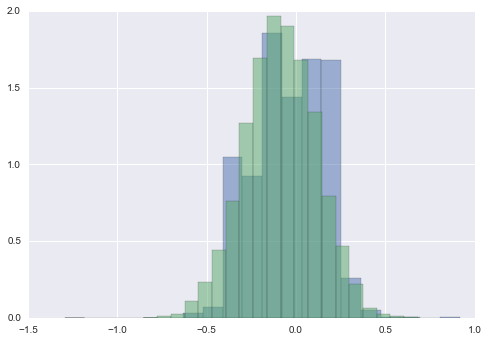

In [23]:
hist(me, 20, alpha=0.5, normed=True)
hist(mn, 20, alpha=0.5, normed=True)
plot_height = ylim()[1]
ctend_plot(med, ci95med, plot_height * .75, colors[0], "median")
ctend_plot(xbar, ci95mean, plot_height * .70, colors[1], "mean")
legend(loc="best");